# Simulating Chemical Reaction Networks with ppsim

``ppsim`` is able to simulate any Chemical Reaction Network (CRN) whose reactions are all bimolecular (two reactant, two product) or unimolecular (one reactant, one product). This notebook shows some examples of that feature, and how it compares to the standard Gillespie stochastic simulation algorithm.

This notebook is intended to be statically readable on GitHub, without needing to run it locally. However, after installing ppsim, you can download the notebook and run its cells to re-generate the data yourself.

In [1]:
import ppsim as pp
import numpy as np
import pickle
import pandas as pd
from matplotlib import pyplot as plt
# Uncomment this line to make all plots interactive
# %matplotlib widget

ModuleNotFoundError: No module named 'ppsim'

# Approximate majority CRN

This 3-state CRN reaches a consensus between the two initial states ``A`` and ``B``. Opposite opinions become undecided ``U`` states, which are then converted by the ``A`` and ``B`` states.

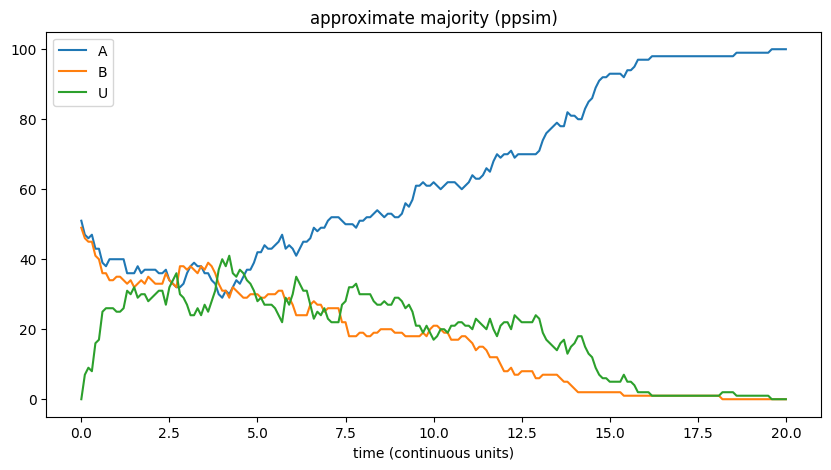

In [2]:
a,b,u = pp.species('A B U')
approx_majority = [
    a+b >> 2*u,
    a+u >> 2*a,
    b+u >> 2*b,
]
n = 10 ** 2
p = 0.51
init_config = {a: p*n, b: (1-p)*n}
sim = pp.Simulation(init_config, approx_majority)
sim.run(20, 0.1)
sim.history.plot(figsize=(10,5)) # .plot(figsize = (6, 4))
plt.title('approximate majority (ppsim)')
plt.show()

Because the input was in the form of a CRN, `ppsim` by default is using the same continuous time model as the Gillespie algorithm. We can check that it is the same by implementing the same protocol using Gillespie simulation with the package [GillesPy2](https://github.com/StochSS/GillesPy2).

2025-01-30 13:26:05,964 - GillesPy2 - WARNING - Unable to use C++ optimized solvers due to one or more missing dependencies: ['g++']. The performance of this package can be significantly increased if you install/configure these on your machine.


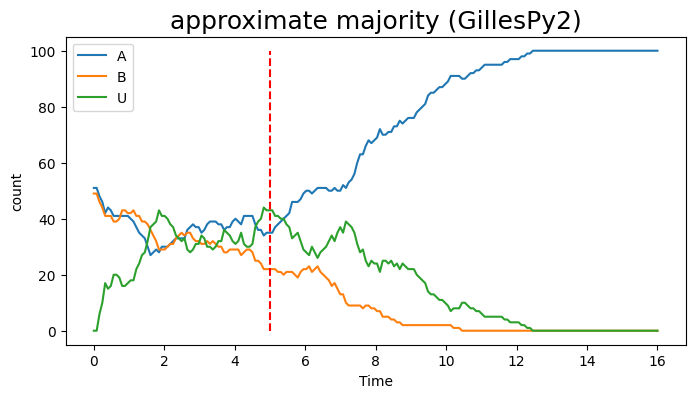

In [3]:
import gillespy2
model = pp.gillespy2_format(init_config, approx_majority, n)
model.timespan(np.linspace(0,16,200))
results = model.run()
results.plot(figsize=(8,4), title='approximate majority (GillesPy2)')
plt.ylabel('count')
end_time = 5
line = plt.vlines(end_time, 0, n, color='r',linestyles = 'dashed')

To test more thoroughly that these two simulations have the exact same distribution, we will sample the probability distribution of a state at time 5.

In [4]:
# # Code that was used to generate the data, which was saved with pickle
# # This is commented out since it is time-consuming to run. 
# # Uncomment the code below to re-run and generate new data for the next figure.
# trials = 10 ** 6
# sim = pp.Simulation(init_config, approx_majority)
# results_ppsim = sim.sample_future_configuration(end_time, num_samples = trials)

# model.timespan(np.linspace(0,end_time,2))
# results_gillespy2 = model.run(number_of_trajectories = trials)
# fig, ax = plt.subplots(figsize = (4,4))
# ax.hist([results_ppsim['A'], [result['A'][1] for result in results_gillespy2]], bins = np.linspace(0, n, 20), 
#                           alpha = 1, label=['ppsim', 'GillesPy2'], density=True, edgecolor = 'k', linewidth = 0.0)
# ax.legend()
# ax.set_xlabel(f'count of state A')
# ax.set_ylabel('empirical probability (10^6 total samples)')
# ax.set_title('state distribution sampled at simulated time 5')

# pickle.dump((fig, ax), open( "crn_data/am_distributions.p", "wb" ) )
# plt.savefig('crn_data/am2.pdf', bbox_inches='tight')

Because we gave a CRN as input, `ppsim` ran with continuous time, and both it and GillesPy2 should be exactly sampling from the same chemical master equation. We will plot both distributions on a histogram to show how well they match.

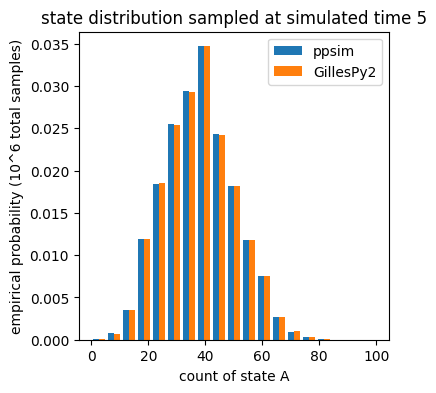

In [5]:
fig, ax = pd.read_pickle( open( "crn_data/am_distributions.p", "rb" ))

Both are sampling from the same distribution, but we will see that `ppsim` can do it much faster for larger population sizes. We will repeatedly sample this approximate majority at time step 10, for varying population sizes, and compute the average running time used per sample generated. We calculate this average time per sample to try to amortize the time spent initializing the simulation and saving data, trying to focus on the runtime of the simulation algorithm itself.

We will compare `ppsim` to GillesPy2, as well as the package [StochKit2](https://academic.oup.com/bioinformatics/article/27/17/2457/224105), which can run multiple variants of Gillespie's algorithm.

In [6]:
from time import perf_counter
from IPython.display import clear_output
import math
import os

def time_trials(simulator, ns, num_trials = 10000, adaptive=True):
    # get data on time it takes ppsim to run rule from init_config until end_time
    times = []
    for n in ns:
        print(f'n = {n:.2E}')
        sim = simulator(n)
        start_time = perf_counter()
        sim.run(num_trials)
        trial_time = (perf_counter() - start_time) / num_trials
        times.append(trial_time)
        # set num_trials to be at most the number that this one could have finished in 10 seconds
        if trial_time > 400:
            break
        if adaptive:
            num_trials = min(num_trials, math.ceil(10 / trial_time))
        clear_output(wait=True)
    return times

# redefining this function will change the rule that the trials use
def sim_params(n):
    # returns init_config, rxns, vol
    return {a: n // 2, b: n // 2}, approx_majority, n

class gillespy2_trials:
    def __init__(self, n):
        self.model = pp.gillespy2_format(*sim_params(n))
        self.model.timespan([0,end_time])
    def run(self, num_trials):
        self.model.run(number_of_trajectories=num_trials)

class ppsim_trials:
    def __init__(self, n):
        self.sim = pp.Simulation(*sim_params(n)[0:2])
    def run(self, num_trials):
        self.sim.sample_future_configuration(end_time, num_trials)
        
# In order to run stochkit_trials, need a stochkit package in the environment variable STOCHKIT_HOME
class stochkit_trials:
    def __init__(self, n):
        # save to build folder, which is in .gitignore
        self.filename = 'build/stochkit_trial.xml'
        init_config, rxns, vol = sim_params(n)
        pp.write_stochkit_file(self.filename, *sim_params(n))
        self.cmd = os.path.join(os.environ['STOCHKIT_HOME'], 'ssa')
    def run(self, num_trials):
        self.cmd += ' -m ' + self.filename + ' -r ' + str(num_trials) + ' -t ' + str(end_time) + ' -f'
        os.system(self.cmd)

In [7]:
# # Code that was used to generate the data, which was saved with pickle
# ns = [int(n) for n in np.geomspace(10 ** 1, 10 ** 12, 23)]
# end_time = 10
# num_trials = 1000
# methods = [ppsim_trials, gillespy2_trials, stochkit_trials]
# method_times2 = [time_trials(method, ns) for method in methods]
# pickle.dump(method_times, open( "crn_data/am_runtimes.p", "wb" ) )

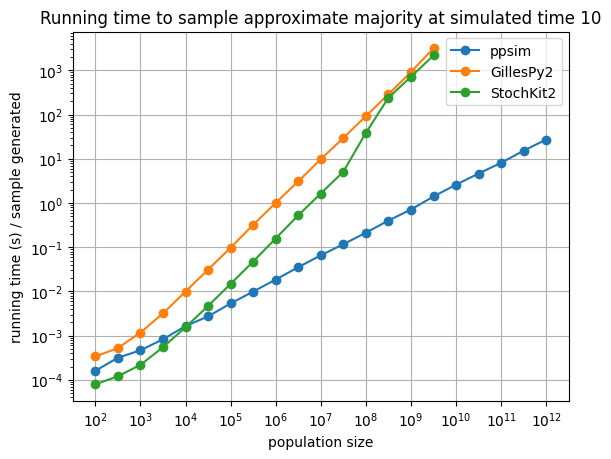

In [8]:
# load the pickled data to plot
method_times = pd.read_pickle( open( "crn_data/am_runtimes.p", "rb" ))
ns = [int(n) for n in np.geomspace(10 ** 1, 10 ** 12, 23)]
fig = plt.figure()
for times in method_times:
    plt.plot(ns[2:len(times)], times[2:], 'o-')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('population size')
plt.ylabel('running time (s) / sample generated')
plt.xticks(ns[2::2])
plt.title('Running time to sample approximate majority at simulated time 10')
plt.legend(['ppsim', 'GillesPy2', 'StochKit2'])
plt.grid()

The runtime plots are reflecting that the Gillespie algorithm implemented by GillesPy2 and StochKit has $O(n)$ runtime (roughly slope 1 on log-log plot), wheras ``ppsim`` has $O(\sqrt{n})$ runtime (roughly slope 1/2 on log-log plot).

Using ``ppsim``, we are able to simulate populations into the trillions. This lets us exactly simulate counts of molecules approaching those used in real experiments. This approximate majority protocol has been implemented experimentally by DNA strand displacement in [this paper](https://pubmed.ncbi.nlm.nih.gov/24077029/). We can set the approximate majority rate constants to be effective rate constants from the paper, and using the concentration 80 nM from the paper in a volume of 1 microliter, we have a system of nearly $10^{11}$ molecules, which can be ``ppsim`` can handle. We note that the actual reactions implemented experimentally in the paper are dozens of DNA strand displacement reactions that implement the 3-reaction protocol. What is shown below is not this; it is just the three "abstract" reactions doing approximate majority directly. (But with simulated experimental conditions set to be realistic, assuming one could find chemicals implementing the approximate majority reactions more directly than DNA strand displacement.)

In [9]:
# derived rate constants of the formal reaction simulated by DNA strand displacement (units of /M/s)
k1,k2,k3 = 9028, 2945, 1815
total_concentration = 80 * 1e-9 # 1x volume was 80 nM
vol = 1e-6 # 1 uL
n = pp.concentration_to_count(total_concentration, vol)
approx_majority_rates = [
    (a+b >> 2*u).k(k1, units=pp.RateConstantUnits.mass_action),
    (a+u >> 2*a).k(k2, units=pp.RateConstantUnits.mass_action),
    (b+u >> 2*b).k(k3, units=pp.RateConstantUnits.mass_action),
]
# set the initial concentrations near where the the mass-action CRN would reach an unstable equilibrium
p = 0.45
init_config = {a: int(p*n), b: int((1-p)*n)}
sim = pp.Simulation(init_config, approx_majority_rates, volume=vol, time_units='seconds')

CPU times: total: 11.5 s
Wall time: 11.5 s


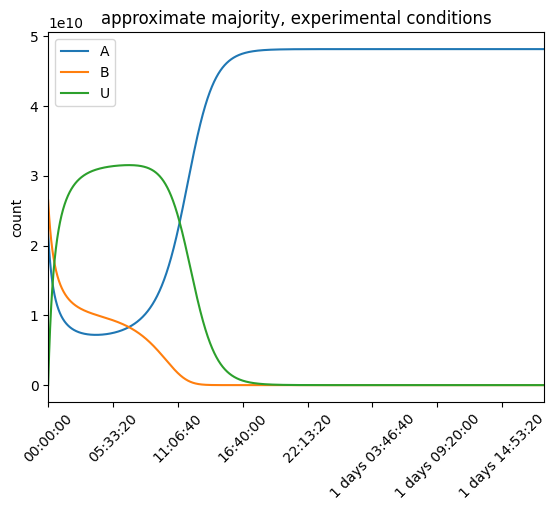

In [10]:
# In non-interactive mode, we wait to run the simulation before plotting
%time sim.run()
sim.history.plot()
plt.title('approximate majority, experimental conditions')
plt.ylabel('count')
plt.xticks(rotation=45)
plt.show()

In [11]:
# # If we are in interactive matplotlib mode (%matplotlib widget), then we can view the plot in real time while the simulation is running
# sim.reset()
# hp = pp.HistoryPlotter()
# sim.add_snapshot(hp)

In [12]:
# # First the HistoryPlotter must be added in one cell, then run has to be called in the next cell to see live updates
# sim.run()
# hp.ax.set_title('approximate majority, experimental conditions')
# hp.ax.set_ylabel('count')

# Large State Speed Tests

The core of `ppsim` uses batching algorithms from [this paper](https://arxiv.org/abs/2005.03584). Theoretically, the time for the basic batching algorithm to simulate $\Theta(\sqrt{n})$ scales in the worst case as $O(q^2)$, where $q$ is the total number of states. The MultiBatch variant improves this worse case scaling to $O(q\sqrt{\log(n)})$ to simulate $\Theta(\sqrt{n})$ interactions, so the asymptotic gains in runtime only apply to state sets $q = o(\sqrt{n})$.

We will now test how this running time scales with number of states. The 3-state approximate majority CRN was one of the best possible cases, so we will now run some speed tests with parameterized CRNs that have a variable number of states.

We found StochKit2 to be much more competitive in these trials, so we will only show comparisons between in and `ppsim`. We will fix the population size $n = 10^4$, which was the spot where both algorithms had the same runtime for approximate majority. By only varying the number of states in the protocol, we will then isolate the effect of increased state set.

These effects crucially depend on the number of types of reactions, so we will try a few different CRNs. The first example will be a chain of unimolecular decay reactions, where each of `m` states decays into the next. The reactions are
$$s_0 \rightarrow s_1 \rightarrow s_2 \rightarrow \ldots \rightarrow s_{m-1}$$

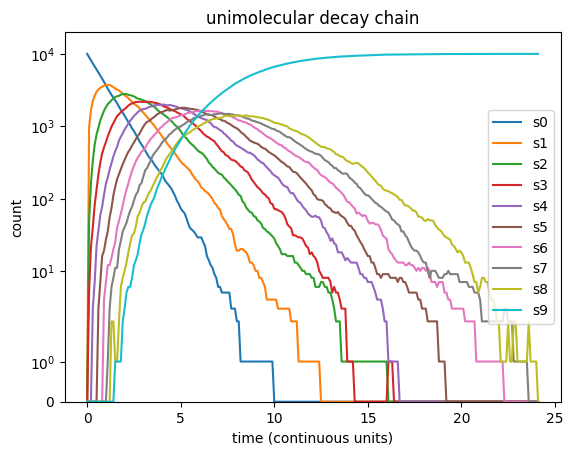

In [13]:
def get_unimolecular_chain(m):
    # create reactions with m species s0, ..., s(m-1)
    states = pp.species(' '.join(['s' + str(i) for i in range(m)]))
    rxns = [states[i] >> states[i+1] for i in range(m-1)]
    return states, rxns
states, rxns = get_unimolecular_chain(10)
n = 10000
sim = pp.Simulation({states[0]: n}, rxns)
sim.run(history_interval=0.1)
sim.history.plot()
plt.ylabel('count')
plt.yscale('symlog')
plt.ylim(0, 2*n)
plt.title('unimolecular decay chain')
plt.show()

This plot with time on a linear scale and counts on a log scale shows that each state is successively decaying exponentially to 0.

Unlike in the above plot, our comparisons will use an initial configuration which is a uniform mix of all `m` states, and run to simulated time 10. This is to ensure that we can test for a fixed amount of time and have all reactions be active simulatenously.

In [14]:
n = 10 ** 4
end_time = 10

# Redefine the sim_params function
def sim_params(m):
    # returns init_config, rxns, vol
    states, rxns = get_unimolecular_chain(m)
    return {state:n // m for state in states}, rxns, n

In [15]:
# # Code that was used to generate the data, which was saved with pickle
# ms = [int(m) for m in np.linspace(2, 200, 20)]
# methods = [ppsim_trials, stochkit_trials]
# method_times = [time_trials(method, ms, num_trials=1000, adaptive=False) for method in methods]
# pickle.dump(method_times, open( "crn_data/unimolecular_runtimes.p", "wb" ) )

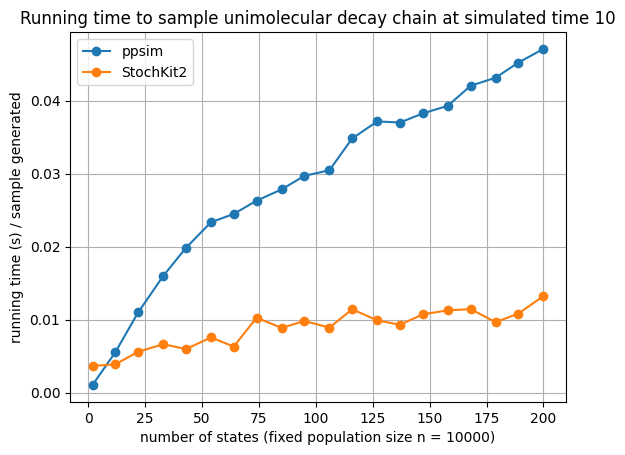

In [16]:
# load the pickled data to plot
method_times = pd.read_pickle( open( "crn_data/unimolecular_runtimes.p", "rb" ))
ms = [int(m) for m in np.linspace(2, 200, 20)]
fig = plt.figure()
for times in method_times:
    plt.plot(ms[:len(times)], times, 'o-')
# plt.xscale('log')
# plt.yscale('log')
plt.xlabel('number of states (fixed population size n = 10000)')
plt.ylabel('running time (s) / sample generated')
plt.title('Running time to sample unimolecular decay chain at simulated time 10')
plt.legend(['ppsim', 'StochKit2'])
plt.grid()

We can see for this example that holding the number of states fixed, `ppsim` scales worse in terms of number of states than StochKit2. As expected, the time is scaling linearly with `ppsim`, whereas the change in StochKit's running time is very marginal.
Note that the largest state set $q = 200 > \sqrt{n}$ for this fixed value $n = 10^4$, so it was not expected for MultiBatch to outperform a more direct sequential population protocol simulation in this case.

But we will now check that even for large state sets, the gains from MultiBatch are still large as we look at larger population sizes. We will fix the state set $m=200$ to be constant, as $n$ increases starting from $n = 10^4$.

In [17]:
end_time = 10
m = 200
def sim_params(n):
    # returns init_config, rxns, vol
    states, rxns = get_unimolecular_chain(m)
    return {state:n // m for state in states}, rxns, n

# # Code that was used to generate the data, which was saved with pickle
# ns = [int(n) for n in np.geomspace(10 ** 4, 10 ** 10, 13)]
# methods = [ppsim_trials, stochkit_trials]
# method_times2 = [time_trials(method, ns, num_trials=100) for method in methods]
# pickle.dump(method_times, open( "crn_data/unimolecular_runtimes2.p", "wb" ) )

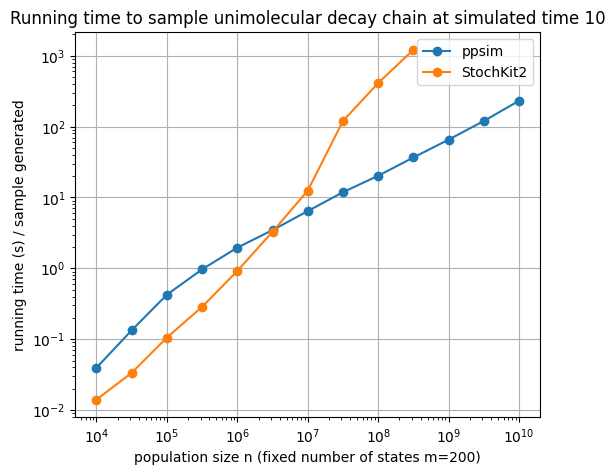

In [18]:
# load the pickled data to plot
method_times = pd.read_pickle( open( "crn_data/unimolecular_runtimes2.p", "rb" ))
ns = [int(n) for n in np.geomspace(10 ** 4, 10 ** 10, 13)]
fig = plt.figure(figsize=(6,5))
for times in method_times:
    plt.plot(ns[:len(times)], times, 'o-')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('population size n (fixed number of states m=200)')
plt.ylabel('running time (s) / sample generated')
plt.title('Running time to sample unimolecular decay chain at simulated time 10')
plt.legend(['ppsim', 'StochKit2'])
plt.grid()

Next we will look at a chain where each reaction is bimolecular:
$$2s_0 \rightarrow 2s_1 \rightarrow 2s_2 \rightarrow \ldots \rightarrow 2s_{m-1}$$

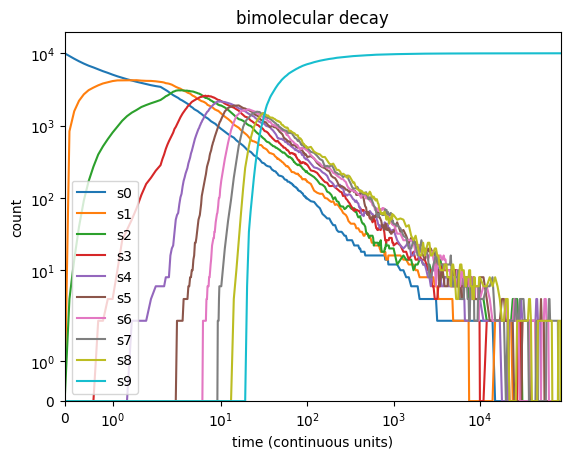

In [19]:
def get_bimolecular_chain(m):
    # create reactions with m species s0, ..., s(m-1)
    states = pp.species(' '.join(['s' + str(i) for i in range(m)]))
    rxns = [2*states[i] >> 2 * states[i+1] for i in range(m-1)]
    return states, rxns
states, rxns = get_bimolecular_chain(10)
n = 10 ** 4
sim = pp.Simulation({states[0]: n}, rxns)
# Setting history_interval to be a function lets the recorded timesteps be evenly spaced on a log plot
sim.run(history_interval=lambda t: 10 ** len(str(int(t))) / 100)
sim.history.plot()
plt.xscale('symlog')
plt.xlim(0, sim.times[-1])
plt.yscale('symlog')
plt.ylabel('count')
plt.ylim(0, 2*n)
plt.title('bimolecular decay')
plt.show()

Now a plot with time and counts on a log scale shows that each state successive decays polynomially to 0. Because `ppsim` dynamically switches to Gillespie's algorithm when the number of null interactions gets very high, it can quickly go out to large times if the system is waiting on a small number of reactions to complete.

Again, unlike in the above plot, our comparisons will use an initial configuration which is a uniform mix of all `m` states, and run to simulated time 10. This is to ensure that we can test for a fixed amount of time and have all reactions be active simulatenously. Note that the probability of an active reaction decreases as we increase the state set `m`. This means the number of non-null interactions that happen in 10 units of time will decrease. The optimized Gillespie algorithm of StockKit2 will thus need to simulate fewer reactions, whereas the MultiBatch algorithm for `ppsim` needs to simulate these null interactions as well. As the probability of a null interaction grows, the relative advantage of MultiBatch drops, until eventually when this probability of a null interaction gets sufficiently high, `ppsim` will switch to a direct Gillespie algorithm. This bimolecular chain is thus representing the worst case for `ppsim`, because increasing the parameter `m` directly increases the probability of a null interaction.

In [20]:
n = 10 ** 4
end_time = 10

def sim_params(m):
    # returns init_config, rxns, vol
    states, rxns = get_bimolecular_chain(m)
    return {state:n // m for state in states}, rxns, n

In [21]:
# # Code that was used to generate the data, which was saved with pickle
# ms = [int(m) for m in np.linspace(2, 200, 20)]
# methods = [ppsim_trials, stochkit_trials]
# method_times = [time_trials(method, ms, num_trials=100, adaptive=False) for method in methods]
# pickle.dump(method_times, open( "crn_data/bimolecular_runtimes.p", "wb" ) )

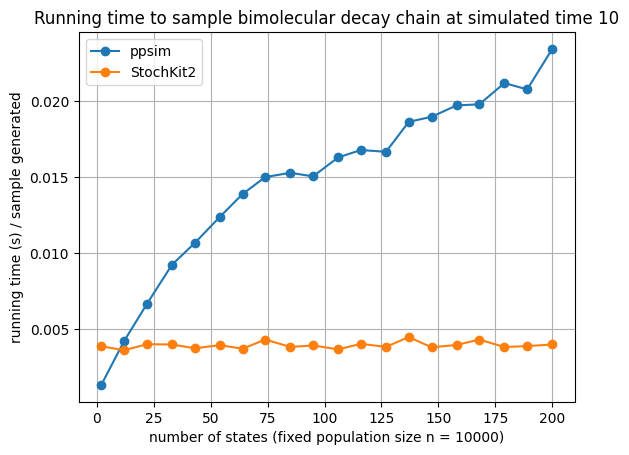

In [22]:
# load the pickled data to plot
method_times = pd.read_pickle( open( "crn_data/bimolecular_runtimes.p", "rb" ))
ms = [int(m) for m in np.linspace(2, 200, 20)]
fig = plt.figure()
for times in method_times:
    plt.plot(ms[:len(times)], times, 'o-')
plt.xlabel('number of states (fixed population size n = 10000)')
plt.ylabel('running time (s) / sample generated')
plt.title('Running time to sample bimolecular decay chain at simulated time 10')
plt.legend(['ppsim', 'StochKit2'])
plt.grid()

We see the a similar linear increase in running time with respect to number of states from `ppsim`. The running time for StockKit2 doesn't change at all, as the cost to handle a larger number of states is being offset by the fact that fewer reactions happen by simulated time 10.

Again, we will take the largest number 200 of states and now increase the population size, to see when `ppsim` becomes more efficient.

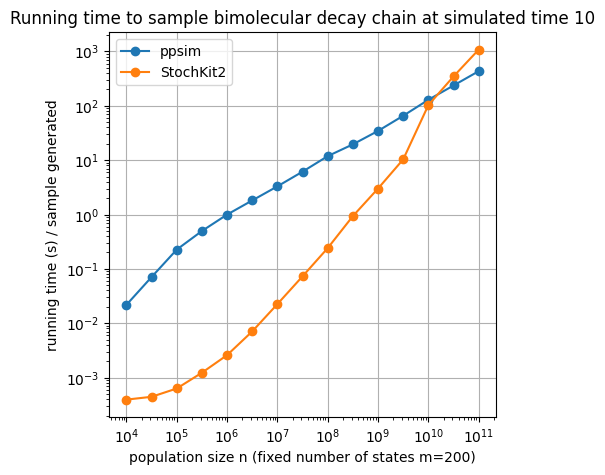

In [23]:
end_time = 10
m = 200
n = 10 ** 4
def sim_params(n):
    # returns init_config, rxns, vol
    states, rxns = get_bimolecular_chain(m)
    return {state:n // m for state in states}, rxns, n

# # Code that was used to generate the data, which was saved with pickle
# ns = [int(n) for n in np.geomspace(10 ** 3, 10 ** 12, 19)]
# methods = [ppsim_trials, stochkit_trials]
# method_times = [time_trials(method, ns, num_trials=1000) for method in methods]
# pickle.dump(method_times, open( "crn_data/bimolecular_runtimes2.p", "wb" ) )

# load the pickled data to plot
method_times = pd.read_pickle( open( "crn_data/bimolecular_runtimes2.p", "rb" ))
ns = [int(n) for n in np.geomspace(10 ** 3, 10 ** 12, 19)]
fig = plt.figure(figsize=(5,5))
for times in method_times:
    plt.plot(ns[2:len(times)], times[2:], 'o-')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('population size n (fixed number of states m=200)')
plt.ylabel('running time (s) / sample generated')
plt.title('Running time to sample bimolecular decay chain at simulated time 10')
plt.legend(['ppsim', 'StochKit2'])
plt.grid()

The very high probability of null reactions imposes a significant constant-factor penalty to `ppsim`, but still its quadratic speedup eventually overcomes this disadvantage for sizes $n \geq 10^{10}$.

We will next check at a more reasonable state space of $m=50$ for a further comparison.

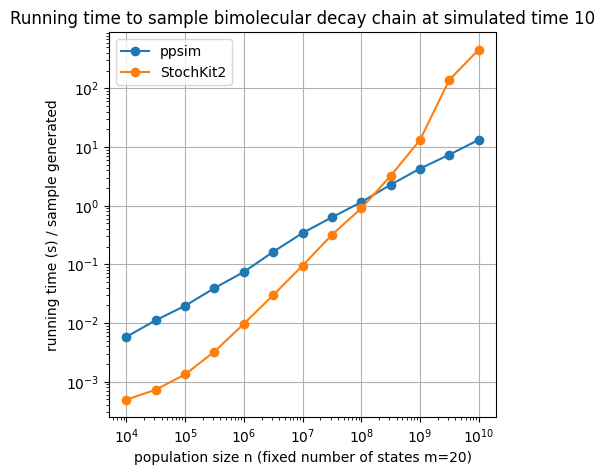

In [24]:
end_time = 10
m = 20
n = 10 ** 4
def sim_params(n):
    # returns init_config, rxns, vol
    states, rxns = get_bimolecular_chain(m)
    return {state:n // m for state in states}, rxns, n

# # Code that was used to generate the data, which was saved with pickle
# ns = [int(n) for n in np.geomspace(10 ** 3, 10 ** 10, 15)]
# methods = [ppsim_trials, stochkit_trials]
# method_times = [time_trials(method, ns, num_trials=1000) for method in methods]
# pickle.dump(method_times, open( "crn_data/bimolecular_runtimes3.p", "wb" ) )

# load the pickled data to plot
method_times = pd.read_pickle( open( "crn_data/bimolecular_runtimes3.p", "rb" ))
ns = [int(n) for n in np.geomspace(10 ** 3, 10 ** 10, 15)]
fig = plt.figure(figsize=(5,5))
for times in method_times:
    plt.plot(ns[2:len(times)], times[2:], 'o-')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('population size n (fixed number of states m=20)')
plt.ylabel('running time (s) / sample generated')
plt.title('Running time to sample bimolecular decay chain at simulated time 10')
plt.legend(['ppsim', 'StochKit2'])
plt.grid()

Finally, we will consider a parameterized discrete averaging rule, with reactions
$$s_i + s_j \rightarrow s_{\lfloor{\frac{i+j}{2}}\rfloor} + s_{\lceil{\frac{i+j}{2}}\rceil}$$
Starting from states $s_0$ and $s_{m-1}$, all $m$ states will soon become present via these averaging rules. Unlike our first two examples, now the total number of reactions is $O(m^2)$, as almost all pairs have a non-null interaction (as long as $|i-j|>1$ then $s_i$ and $s_j$ have an active reaction). This change makes no difference for `ppsim`, but will make the simulation much more expensive for GillesPy2.

In [25]:
def get_discrete_averaging(m):
    # create reactions with m species s0, ..., s(m-1)
    states = pp.species(' '.join(['s'+str(i) for i in range(m)]))
    rxns = []
    for i in range(m):
        for j in range(i):
            avg = (i + j) / 2
            rxns.append(states[i] + states[j] >> states[math.floor(avg)] + states[math.ceil(avg)])
    return states, rxns

In [26]:
n = 10 ** 4
end_time = 10

def sim_params(m):
    # returns init_config, rxns, vol
    states, rxns = get_discrete_averaging(m)
    return {states[0]: n // 2, states[m-1]: n // 2}, rxns, n

In [27]:
# # Code that was used to generate the data, which was saved with pickle
# ms = [int(m) for m in np.linspace(3, 200, 20)]

# methods = [ppsim_trials, stochkit_trials]
# method_times = [time_trials(method, ms, num_trials=100) for method in methods]
# pickle.dump(method_times, open( "crn_data/discrete_averaging_runtimes.p", "wb" ) )

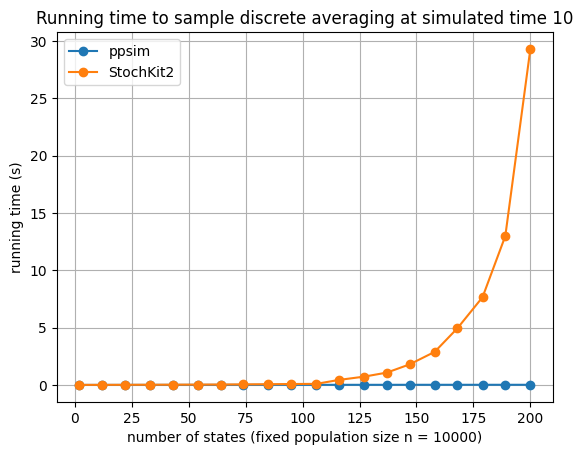

In [28]:
# load the pickled data to plot
method_times = pd.read_pickle( open( "crn_data/discrete_averaging_runtimes.p", "rb" ))
fig, ax = plt.subplots()
for times in method_times:
    plt.plot(ms[:len(times)], times, 'o-')
# plt.yscale('log')
# plt.ylim(0, 2)
plt.xlabel('number of states (fixed population size n = 10000)')
plt.ylabel('running time (s)')
plt.title('Running time to sample discrete averaging at simulated time 10')
plt.legend(['ppsim', 'StochKit2'])
plt.grid()

As the number of states grows, the quadratic growth in the number of reactions to be processed by StochKit2 becomes very expensive. For `ppsim`, on the other hand, there is little difference between this CRN and the previous rules, since its scaling is only on the number of states.

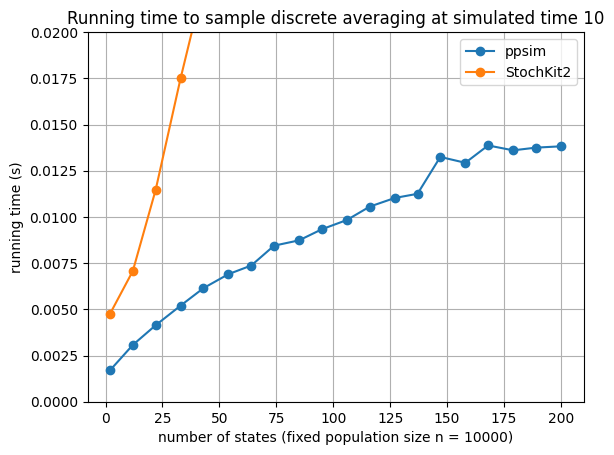

In [29]:
ax.set_ylim(0,0.02)
display(fig)

# RPS Oscillator

We will now look at a simple 3-state CRN with oscillatory dynamics, given by the reactions
$$B+A \rightarrow B + B$$
$$C + B \rightarrow C + C$$
$$A + C \rightarrow A + A$$

The behavior of this CRN under the exact stochastic dyanamics which are sampled by Gillespie's algorithm turns out to be very delicate. This example will show that common approximations to quickly simulate this CRN for large state sizes, both $\tau$-leaping and ODE simulation, each have qualitatively different behavior from the true stochastic simulation.

In [30]:
# CRN for rps oscillator
a,b,c = pp.species('A B C')
rps = [
    b+a >> 2*b,
    c+b >> 2*c,
    a+c >> 2*a,
]
n = 10 ** 4
dist = [0.2, 0.3, 0.5]
init_config = {a: n * dist[0], b: n * dist[1], c: n * dist[2]}

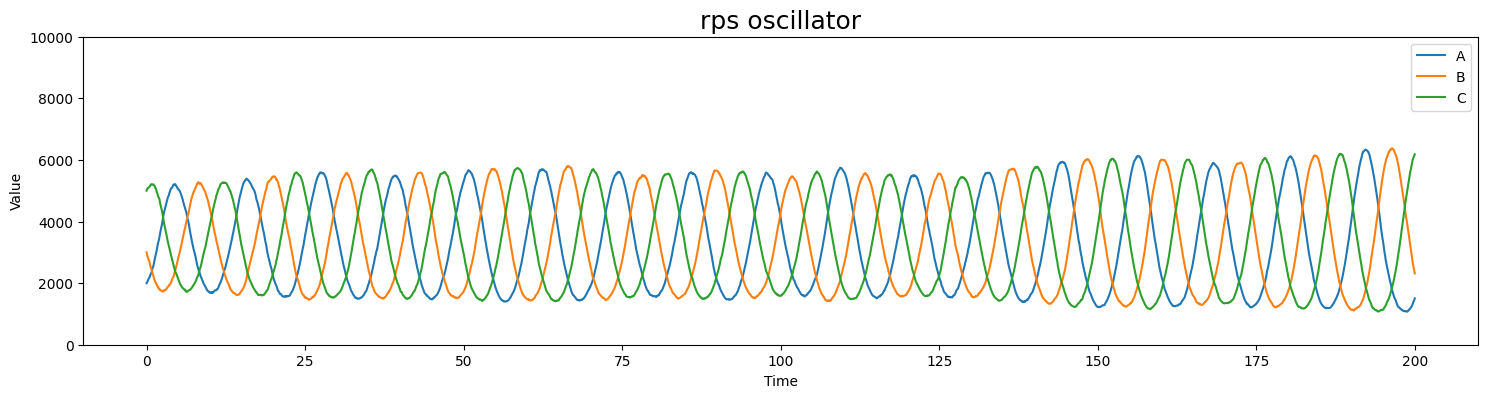

In [31]:
model = pp.gillespy2_format(init_config, rps, n)
model.timespan(np.linspace(0,200,3000))
results = model.run()
results.plot(figsize = (18, 4), title='rps oscillator')
plt.ylim(0, n)
plt.show()

The amplitude of the oscillations randomly drifts up and down during the simulation. For another way to visualize these dynamics, we can take a look at the curves traced out in phase space.

In [32]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import warnings
# Need the scipy package to plot ODE solutions
from scipy.integrate import solve_ivp

def odes(t, y):
    a, b, c = y[0], y[1], y[2]
    return a*(c-b), b*(a-c), c*(b-a)

def phase_plot(results):
     # Some warnings appear only when in %matplotlib inline mode
    warnings.filterwarnings("ignore", category=RuntimeWarning)
        
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    verts = [[n,0,0],[0,n,0],[0,0,n]]

    simplex = Poly3DCollection([verts], edgecolors='k', facecolors='w', alpha=0.1)
    ax.scatter(*np.array(verts), color='k')
    ax.add_collection3d(simplex)
    e = 0.05
    ax.text((1-2*e)*n, e*n, e*n, 'A')
    ax.text(e*n, (1-2*e)*n, e*n, 'B')
    ax.text(e*n, e*n, (1-2*e)*n, 'C')

    ax.plot(results['A'], results['B'], results['C'], lw=0.5, label='stochastic trajectory')
    ax.set_xlabel('A')
    ax.set_ylabel('B')
    ax.set_zlabel('C')
    ax.set_xlim(0, n)
    ax.set_ylim(0, n)
    ax.set_zlim(0, n)
    ax.set_title("rps oscillator")
    ax.view_init(20, 60)
    ax.grid(False)

    start = np.array([results['A'][0], results['B'][0], results['C'][0]])
    end = np.array([results['A'][-1], results['B'][-1], results['C'][-1]])
    ax.scatter(*start, c='g', edgecolor='k', label='start')
    ax.scatter(*end, c='r', edgecolor='k', label='end')

    t_max = 20
    start = start / n
    sol = solve_ivp(odes, [0,t_max], start, dense_output=True)
    ax.plot(*(sol.sol(np.linspace(0,t_max,100 * t_max)) * n + 0.001*n), color='k', label='ODE trajectory', lw=1)
    ax.legend(loc='upper left')
    plt.show()
    return(fig, ax)

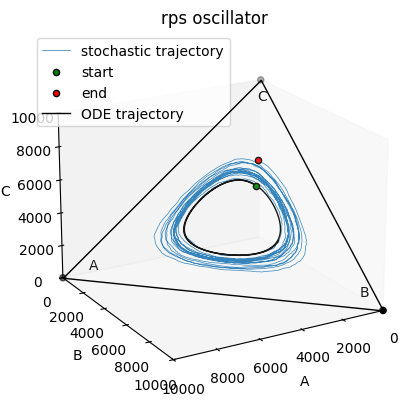

In [33]:
fig, ax = phase_plot(results)

In phase space the dynamics live on the simplex $A+B+C=n$.
The ODE solutions are neutrally stable orbits, wheras the true dynamics have a randomly fluctuating amplitude. On a sufficiently long timescale, this leads to a stark qualitative difference. The ODE will oscillate indefinitely, but the true stochastic dynamics will eventually crash, with one species taking over, hitting one of the corners of the simplex. We can tell `ppsim` to run without a time bound to see how long it runs before crashing.

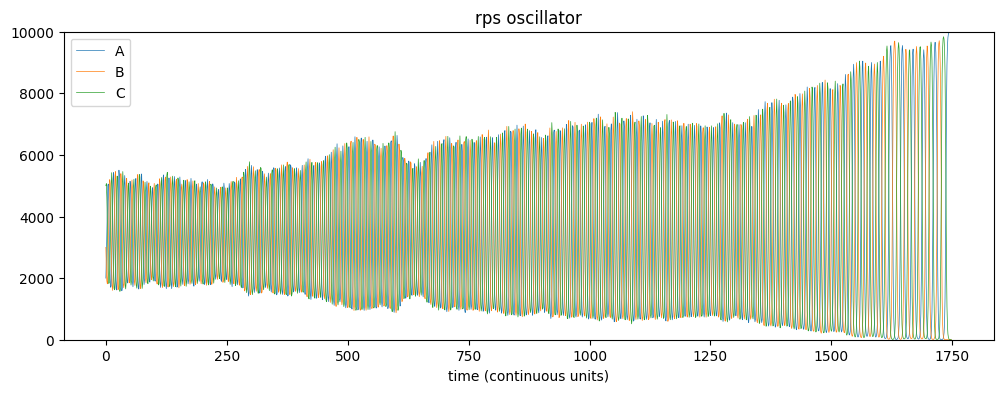

In [34]:
n = 10 ** 4
dist = [0.2, 0.3, 0.5]
init_config = {a: n * dist[0], b: n * dist[1], c: n * dist[2]}
sim = pp.Simulation(init_config, rps)
sim.run()
sim.history.plot(figsize = (12,4), linewidth=0.5)
plt.ylim(0, n)
plt.title('rps oscillator')
plt.show()

Now we will take a look a larger population size of one million. Here `ppsim` is able to simulate out to time 300 in about 1 second.

CPU times: total: 219 ms
Wall time: 218 ms


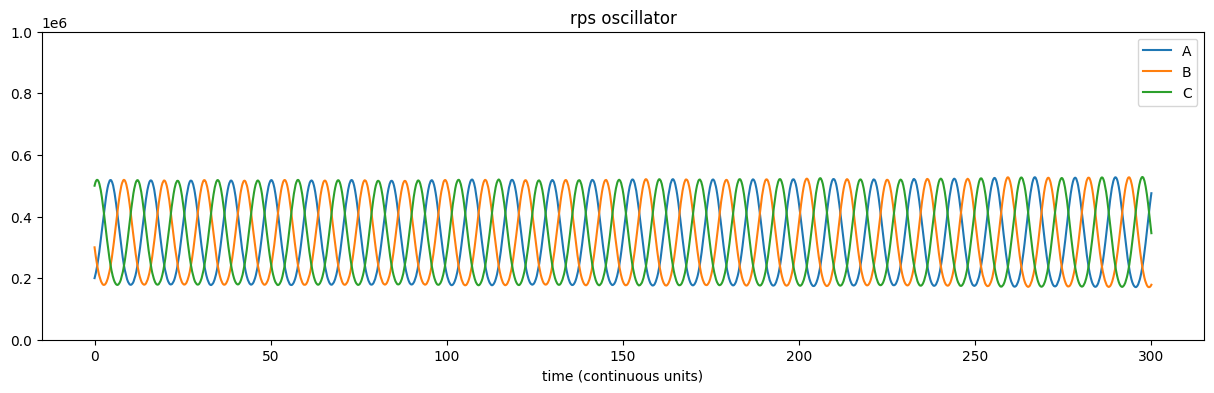

In [35]:
n = 10 ** 6
dist = [0.2, 0.3, 0.5]
init_config = {a: n * dist[0], b: n * dist[1], c: n * dist[2]}
sim = pp.Simulation(init_config, rps)
%time sim.run(300, 0.01)
sim.history.plot(figsize = (15,4))
plt.ylim(0, n)
plt.title('rps oscillator')
plt.show()

At this scale, the plot does not look qualitatively different from the ODEs. But if we take a closer look in phase space, we can still see that the orbits are fluctuating randomly. These fluctuations would not appear in the ODE solution.

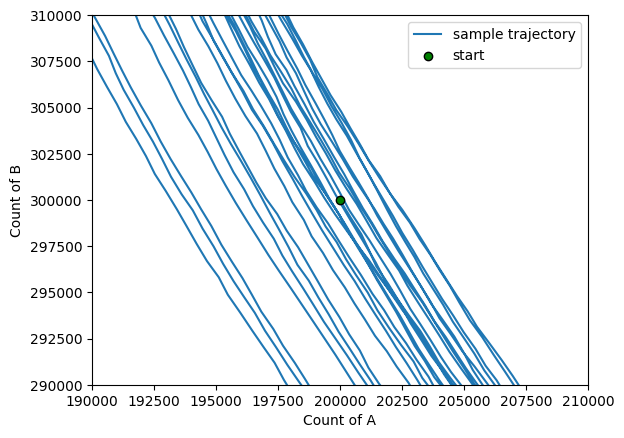

In [36]:
plt.figure()
plt.plot(sim.history['A'],sim.history['B'], label='sample trajectory')
init_a, init_b = sim.history['A'][0], sim.history['B'][0]
plt.scatter(init_a, init_b, color='g', zorder=4, edgecolor='k', label='start')
r = 10 ** 4
plt.xlim(init_a - r, init_a + r)
plt.ylim(init_b - r, init_b + r)
plt.xlabel('Count of A')
plt.ylabel('Count of B')
plt.legend(loc='upper right')
plt.show()

$\tau$-leaping attempts to model the stochastic trajectories, with a speedup that assumes propensities do not change over longer periods. Here we set the `tau_tol` parameter for GillesPy2 `TauLeapingSolver` to yield a simulation time of about 1 second, comparable to `ppsim`.

CPU times: total: 281 ms
Wall time: 275 ms


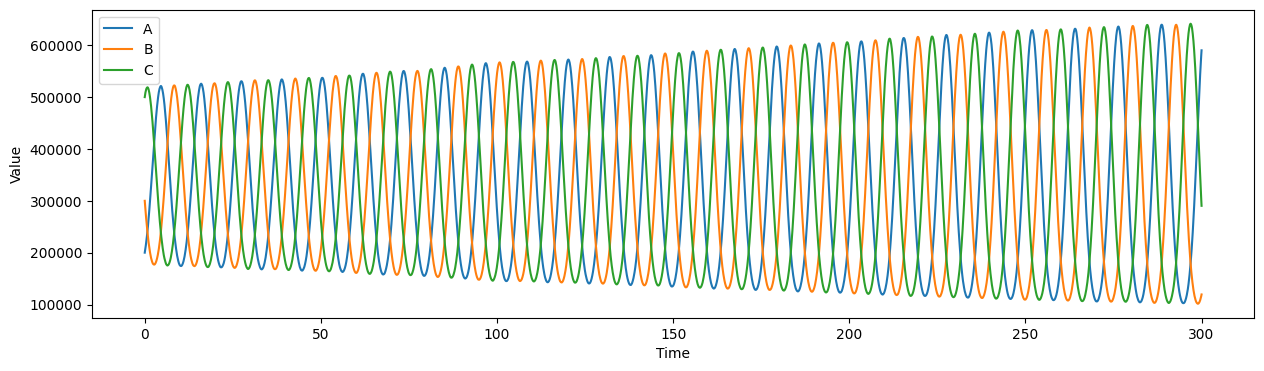

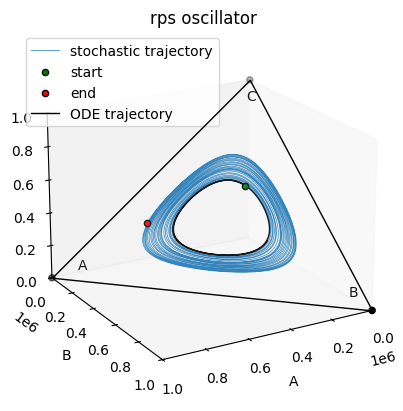

In [37]:
import gillespy2
n = 10 ** 6
dist = [0.2, 0.3, 0.5]
init_config = {a: n * dist[0], b: n * dist[1], c: n * dist[2]}
model = pp.gillespy2_format(init_config, rps, n)
model.timespan(np.linspace(0,300,3000))
%time results=model.run(solver=gillespy2.TauLeapingSolver, tau_tol = 0.02)
results.plot(figsize = (15, 4))
fig, ax = phase_plot(results)

The plots show a very clear and steady outward drift, that was not present in the true dynamics. This will cause the system to crash much sooner than the true stochastic system.

Simulating for a longer period of time, we can the system go extinct in less than $\sqrt{n}$ time.

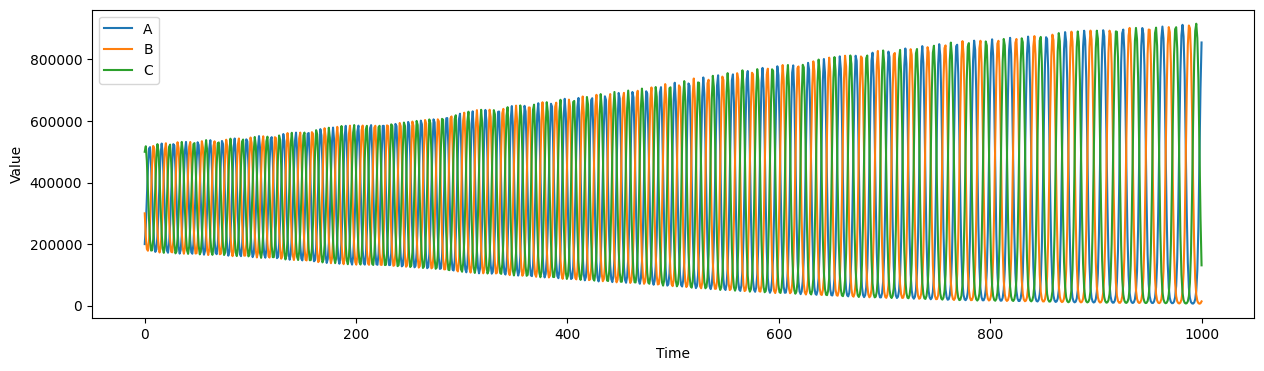

In [38]:
n = 10 ** 6
dist = [0.2, 0.3, 0.5]
init_config = {a: n * dist[0], b: n * dist[1], c: n * dist[2]}
model = pp.gillespy2_format(init_config, rps, n)
model.timespan(np.linspace(0,1000,1000))
results=model.run(solver=gillespy2.TauLeapingSolver,tau_tol = 0.02)
results.plot(figsize = (15, 4))

Also note that similar issues will come up with attempts to simulate the ODEs for long periods, where numerical errors build up and cause a bias that keeps the system from remaining in one orbit.

# DSD oscillator 

This rock-paper-scissors (RPS) oscillator was implemented using DNA strand displacement in http://dx.doi.org/10.1126/science.aal2052 (bioRxiv verion: https://www.biorxiv.org/content/10.1101/138420v2). Figure 1 from the paper gives a quick summary:

<img src="https://science.sciencemag.org/content/sci/358/6369/eaal2052/F1.large.jpg" width="600" />

The implementation (itself also using only 2-input/2-output reactions) uses 45 total DNA species with 8 DNA reactions per formal reaction above (i.e., 24 total DNA reactions).
Our simulation uses the same concentrations (around 10-100 nM), though a somewhat smaller volume by a few orders of magnitude (10 nL) than that used in the real experiment.
Under these conditions the simulation is close to real-time:
a couple seconds of real time per second of simulated time.
(Since the actual experiment ran for hours, this was taxing even for our algorithm.)
For simplicity we did not include the full set of simulated reactions (such as leak reactions and toehold occlusion reactions) described in the paper.

In [39]:
from ppsim import species
# Fig. 1 in https://www.biorxiv.org/content/10.1101/138420v2.full.pdf
# A+B --> 2B
# B+C --> 2C
# C+A --> 2A

# signal species (represent formal species in formal CRN above)
# index indicates whether it was the first or second product of a previous reaction
b1, b2, c1, c2, a1, a2 = pp.species('b1  b2  c1  c2  a1  a2')

signal_species = [b1, b2, c1, c2, a1, a2]

# fuel species react step
react_a_b_b1, back_a_b = species('react_a_b_b1  back_a_b')
react_b_c_c1, back_b_c = species('react_b_c_c1  back_b_c')
react_c_a_a1, back_c_a = species('react_c_a_a1  back_c_a')

react_species = [react_a_b_b1, react_b_c_c1, react_c_a_a1]
back_species = [back_a_b, back_b_c, back_c_a]

# fuel species produce step
produce_b_b1_b2, helper_b_b2 = species('produce_b_b1_b2  helper_b_b2')
produce_c_c1_c2, helper_c_c2 = species('produce_c_c1_c2  helper_c_c2')
produce_a_a1_a2, helper_a_a2 = species('produce_a_a1_a2  helper_a_a2')

produce_species = [produce_b_b1_b2, produce_c_c1_c2, produce_a_a1_a2]
helper_species = [helper_b_b2, helper_c_c2, helper_a_a2]
fuel_species = react_species + produce_species

# intermediate species
flux_b_b1, flux_c_c1, flux_a_a1 = species('flux_b_b1  flux_c_c1  flux_a_a1')
reactint_a1_b_b1, reactint_b1_c_c1, reactint_c1_a_a1 = species('reactint_a1_b_b1  reactint_b1_c_c1  reactint_c1_a_a1') 
reactint_a2_b_b1, reactint_b2_c_c1, reactint_c2_a_a1 = species('reactint_a2_b_b1  reactint_b2_c_c1  reactint_c2_a_a1') 
productint_b_b1_b2, productint_c_c1_c2, productint_a_a1_a2 = species('productint_b_b1_b2  productint_c_c1_c2  productint_a_a1_a2')

flux_species = [flux_b_b1, flux_c_c1, flux_a_a1]
reactint_species = [reactint_a1_b_b1, reactint_b1_c_c1, reactint_c1_a_a1,
                    reactint_a2_b_b1, reactint_b2_c_c1, reactint_c2_a_a1]
produceint_species = [productint_b_b1_b2, productint_c_c1_c2, productint_a_a1_a2]

# waste species react step
waste_a1_b1, waste_a1_b2, waste_a2_b1, waste_a2_b2 = species('waste_a1_b1  waste_a1_b2  waste_a2_b1  waste_a2_b2')
waste_b1_c1, waste_b1_c2, waste_b2_c1, waste_b2_c2 = species('waste_b1_c1  waste_b1_c2  waste_b2_c1  waste_b2_c2')
waste_c1_a1, waste_c1_a2, waste_c2_a1, waste_c2_a2 = species('waste_c1_a1  waste_c1_a2  waste_c2_a1  waste_c2_a2')

# waste species produce step
waste_b_b1_b2, waste_c_c1_c2, waste_a_a1_a2 = species('waste_b_b1_b2  waste_c_c1_c2  waste_a_a1_a2')

waste_species = [waste_a1_b1, waste_a1_b2, waste_a2_b1, waste_a2_b2,
                 waste_b1_c1, waste_b1_c2, waste_b2_c1, waste_b2_c2,
                 waste_c1_a1, waste_c1_a2, waste_c2_a1, waste_c2_a2,
                 waste_b_b1_b2, waste_c_c1_c2, waste_a_a1_a2]

# DSD reactions implementing formal CRN
# A+B --> 2B
ab_react_rxns = [
    a1 + react_a_b_b1 | back_a_b + reactint_a1_b_b1,
    a2 + react_a_b_b1 | back_a_b + reactint_a2_b_b1,
    reactint_a1_b_b1 + b1 >> waste_a1_b1 + flux_b_b1, # typo in Fig. 1; these rxns irreversible
    reactint_a1_b_b1 + b2 >> waste_a1_b2 + flux_b_b1, #
    reactint_a2_b_b1 + b1 >> waste_a2_b1 + flux_b_b1, #
    reactint_a2_b_b1 + b2 >> waste_a2_b2 + flux_b_b1, #
]
ab_produce_rxns = [
    flux_b_b1 + produce_b_b1_b2 | b1 + productint_b_b1_b2,
    helper_b_b2 + productint_b_b1_b2 >> waste_b_b1_b2 + b2,
]
ab_rxns = ab_react_rxns + ab_produce_rxns

# B+C --> 2C
bc_react_rxns = [
    b1 + react_b_c_c1 | back_b_c + reactint_b1_c_c1,
    b2 + react_b_c_c1 | back_b_c + reactint_b2_c_c1,
    reactint_b1_c_c1 + c1 >> waste_b1_c1 + flux_c_c1,
    reactint_b1_c_c1 + c2 >> waste_b1_c2 + flux_c_c1,
    reactint_b2_c_c1 + c1 >> waste_b2_c1 + flux_c_c1,
    reactint_b2_c_c1 + c2 >> waste_b2_c2 + flux_c_c1,
]
bc_produce_rxns = [
    flux_c_c1 + produce_c_c1_c2 | c1 + productint_c_c1_c2,
    helper_c_c2 + productint_c_c1_c2 >> waste_c_c1_c2 + c2,
]
bc_rxns = bc_react_rxns + bc_produce_rxns

# C+A --> 2A
ca_react_rxns = [
    c1 + react_c_a_a1 | back_c_a + reactint_c1_a_a1,
    c2 + react_c_a_a1 | back_c_a + reactint_c2_a_a1,
    reactint_c1_a_a1 + a1 >> waste_c1_a1 + flux_a_a1,
    reactint_c1_a_a1 + a2 >> waste_c1_a2 + flux_a_a1,
    reactint_c2_a_a1 + a1 >> waste_c2_a1 + flux_a_a1,
    reactint_c2_a_a1 + a2 >> waste_c2_a2 + flux_a_a1,
]
ca_produce_rxns = [
    flux_a_a1 + produce_a_a1_a2 | a1 + productint_a_a1_a2,
    helper_a_a2 + productint_a_a1_a2 >> waste_a_a1_a2 + a2,
]
ca_rxns = ca_react_rxns + ca_produce_rxns

all_rps_dsd_rxns = ab_rxns + bc_rxns + ca_rxns

all_species = signal_species + \
              react_species + \
              back_species + \
              produce_species + \
              helper_species + \
              flux_species + \
              reactint_species + \
              produceint_species + \
              waste_species

# These functions map states to categories, which allow HistoryPlotter to show a simplified plot of categories
def aux(state):
    if state in react_species:
        return 'react'
    if state in produce_species:
        return 'produce'
    if state in waste_species:
        return 'waste'
    if state in helper_species:
        return 'helper'
    
def abc(state):
    if state in signal_species:
        return state.name[0]

In [40]:
from ppsim import Simulation, RateConstantUnits, concentration_to_count

uL = 10 ** -6  # 1 uL (microliter)
nL = 10 ** -9
nM = 10 ** -9  # 1 nM (nanomolar)

k = 1e6  # forward rate constant in mass-action units
r = 1e6  # reverse rate constant in mass-action units
for rxn in all_rps_dsd_rxns:
    rxn.k(k, units=RateConstantUnits.mass_action)
    if rxn.reversible:
        rxn.r(r, units=RateConstantUnits.mass_action)

vol = 10 * nL

# scale time to make simulations take less time
time_scaling = 1
vol /= time_scaling

react_conc = 100 * nM
back_conc = 100 * nM
helper_conc = 75 * nM
produce_conc = 100 * nM
a1_conc = 11 * nM
b1_conc = 10 * nM
c1_conc = 3 * nM

# this factor scales all concentrations
conc_factor = 1

react_count = concentration_to_count(react_conc * conc_factor, vol)
back_count = concentration_to_count(back_conc * conc_factor , vol)
helper_count = concentration_to_count(helper_conc* conc_factor, vol)
produce_count = concentration_to_count(produce_conc* conc_factor, vol)
a1_count = concentration_to_count(a1_conc* conc_factor, vol)
b1_count = concentration_to_count(b1_conc* conc_factor, vol)
c1_count = concentration_to_count(c1_conc* conc_factor, vol)

init_config_react = {specie: react_count for specie in react_species}
init_config_back = {specie: back_count for specie in back_species}
init_config_helper = {specie: helper_count for specie in helper_species}
init_config_produce = {specie: produce_count for specie in produce_species}

init_config = {a1: a1_count, b1: b1_count, c1: c1_count}
init_config.update(init_config_react)
init_config.update(init_config_back)
init_config.update(init_config_helper)
init_config.update(init_config_produce)

sim = Simulation(init_config=init_config, rule=all_rps_dsd_rxns, volume=vol, time_units='seconds')

We can check the there is over a 99% chance of a null reaction. Thus, similar to `bimolecular_chain`, this example is among the hardest cases for `ppsim`.

In [41]:
sim.null_probability

0.9963641900036009

In [42]:
# # Code that generated the data, saved with pickle
# # Run for 12 simulated hours, recording every 60 seconds
# sim.run(12 * 3600, 60)
# hp = pp.HistoryPlotter(abc, update_time=1)
# hp2 = pp.HistoryPlotter(aux, update_time=1)
# sim.add_snapshot(hp)
# sim.add_snapshot(hp2)
# hp.ax.set_title('Counts of formal species')
# hp2.ax.set_title('Counts of auxilliary species')
# pickle.dump(sim, open( "crn_data/dsd_experiment.p", "wb" ) )

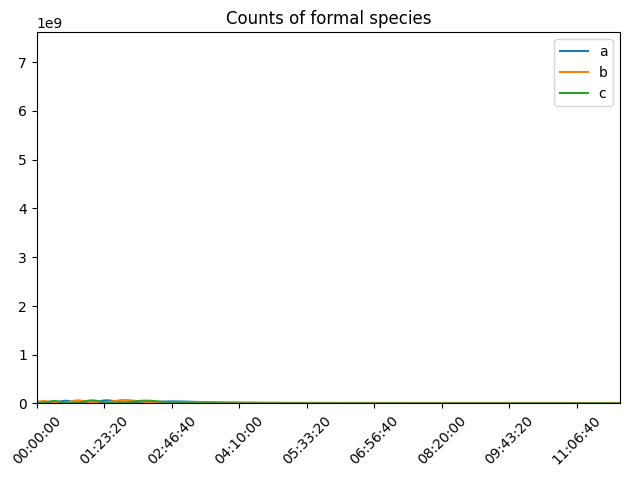

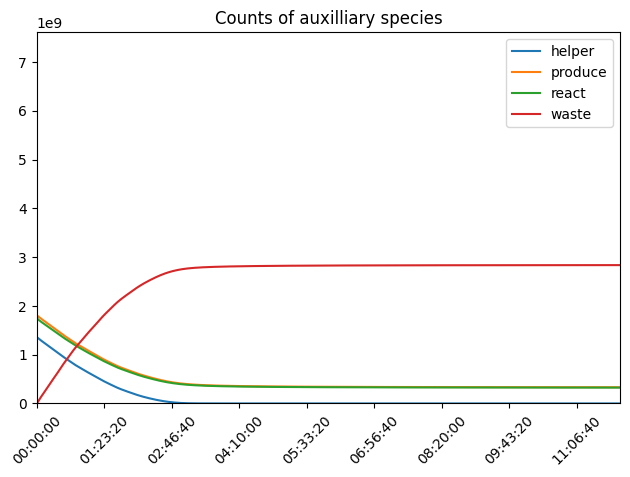

In [43]:
sim = pd.read_pickle( open( "crn_data/dsd_experiment.p", "rb" ))